In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta  # For technical indicators
from alpha_vantage.timeseries import TimeSeries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, classification_report

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries installed and imported successfully!")


In [2]:
# set up API key here: https://www.alphavantage.co/support/#api-key

# Alpha Vantage API key (Replace with your key)
API_KEY = "818L0AZVDJ6XCXX7"

# Initialize Alpha Vantage TimeSeries API
ts = TimeSeries(key=API_KEY, output_format="pandas")

# Fetch 1-hour intraday data for SPY
# Change 'interval' to '1min' if you want minute-level data
symbol = "SPY"  # S&P 500 ETF
interval = "60min"  # Change to "1min" for minute data

# Get data from Alpha Vantage
df, meta_data = ts.get_intraday(symbol=symbol, interval=interval, outputsize="full")

# Rename columns for easier handling
df.columns = ["Open", "High", "Low", "Close", "Volume"]

# Convert index to datetime
df.index = pd.to_datetime(df.index)

# Sort by time (oldest to newest)
df = df.sort_index()

# Display the first few rows
print(df.head())


                       Open    High       Low   Close     Volume
date                                                            
2025-01-27 04:00:00  598.78  599.78  595.6400  595.94   236729.0
2025-01-27 05:00:00  595.97  596.00  589.7500  592.35   469747.0
2025-01-27 06:00:00  592.25  594.20  592.0600  593.18  1075246.0
2025-01-27 07:00:00  593.24  595.67  593.1600  595.02  1259422.0
2025-01-27 08:00:00  593.84  607.97  589.9975  595.74  1114040.0


Next, we create technical features. 

- Lagged Returns: Helps capture short-term price trends.
- Exponential Moving Averages (EMA): Detects momentum and trends.
- Relative Strength Index (RSI): Measures overbought/oversold conditions.
- Moving Average Convergence Divergence (MACD): Measures trend direction and strength.
- On-Balance Volume (OBV): Helps track accumulation and distribution of volume.
- Bollinger Bands: Detects volatility and trend reversals.

In [4]:
# Compute Lagged Returns
df["Return"] = df["Close"].pct_change()

# Compute Exponential Moving Averages (EMA)
df["EMA_5"] = df["Close"].ewm(span=5, adjust=False).mean()
df["EMA_10"] = df["Close"].ewm(span=10, adjust=False).mean()

# Compute Relative Strength Index (RSI)
df["RSI_14"] = ta.momentum.RSIIndicator(df["Close"], window=14).rsi()

# Compute MACD (Moving Average Convergence Divergence)
macd = ta.trend.MACD(df["Close"])
df["MACD"] = macd.macd()
df["MACD_Signal"] = macd.macd_signal()

# Compute On-Balance Volume (OBV)
df["OBV"] = ta.volume.OnBalanceVolumeIndicator(df["Close"], df["Volume"]).on_balance_volume()

# Compute Bollinger Bands
bb = ta.volatility.BollingerBands(df["Close"], window=20, window_dev=2)
df["BB_High"] = bb.bollinger_hband()
df["BB_Low"] = bb.bollinger_lband()

# Drop NaN values caused by indicator calculations
df = df.dropna()

# Display first few rows
print(df.head())


                       Open    High     Low   Close     Volume    Return  \
date                                                                       
2025-01-30 19:00:00  605.98  606.10  605.27  605.91    34925.0  0.000017   
2025-01-30 20:00:00  605.04  605.04  605.04  605.04  1025270.0 -0.001436   
2025-01-31 04:00:00  606.27  608.07  606.25  607.62    29693.0  0.004264   
2025-01-31 05:00:00  607.65  607.90  607.55  607.67    10174.0  0.000082   
2025-01-31 06:00:00  607.65  608.10  607.65  608.10    12908.0  0.000708   

                          EMA_5      EMA_10     RSI_14      MACD  MACD_Signal  \
date                                                                            
2025-01-30 19:00:00  605.473502  604.951740  57.879383  0.567300     0.306431   
2025-01-30 20:00:00  605.329001  604.967787  53.568781  0.545162     0.354177   
2025-01-31 04:00:00  606.092667  605.450008  62.490366  0.727417     0.428825   
2025-01-31 05:00:00  606.618445  605.853643  62.640187  0.8659

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define feature columns (technical indicators)
feature_columns = [
    "Return", "EMA_5", "EMA_10", "RSI_14", "MACD", "MACD_Signal", "OBV", "BB_High", "BB_Low"
]

# Define the target variable (Next return direction: 1 = Up, 0 = Down)
df["Target"] = (df["Return"].shift(-1) > 0).astype(int)

# Drop last row (since shift creates NaN in the last row)
df = df.dropna()

# Define X (features) and y (target)
X = df[feature_columns].values
y = df["Target"].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into Train (80%) and Test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Reshape for LSTM input (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Print dataset shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (232, 9, 1)
X_test shape: (59, 9, 1)
y_train shape: (232,)
y_test shape: (59,)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # LSTM layer
    Dropout(0.2),  # Dropout to prevent overfitting
    LSTM(50, return_sequences=False),  # Second LSTM layer
    Dropout(0.2),
    Dense(25, activation="relu"),  # Dense layer
    Dense(1, activation="sigmoid")  # Output layer (binary classification)
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Print model summary
model.summary()


Epoch 1/20


/Users/heb1/Library/r-miniconda-arm64/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5346 - loss: 0.6922 - val_accuracy: 0.6250 - val_loss: 0.6921
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5473 - loss: 0.6874 - val_accuracy: 0.6667 - val_loss: 0.6912
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5461 - loss: 0.6853 - val_accuracy: 0.4583 - val_loss: 0.6961
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5264 - loss: 0.6948 - val_accuracy: 0.4583 - val_loss: 0.7009
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5793 - loss: 0.6829 - val_accuracy: 0.4583 - val_loss: 0.7044
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5451 - loss: 0.6830 - val_accuracy: 0.4583 - val_loss: 0.7034
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5414 - loss: 0.6845 - val_accuracy: 0.4583 - val_loss: 0.6942
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5769 - loss: 0.6753 - val_accuracy: 0.4583 - val_loss: 0.6947
Epoch 9/20


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 9, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,705 (373.85 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,804 (249.24 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Test Accuracy: 0.4407

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.44      1.00      0.61        26

    accuracy                           0.44        59
   macro avg       0.22      0.50      0.31        59
weighted avg       0.19      0.44      0.27        59



/Users/heb1/Library/r-miniconda-arm64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/heb1/Library/r-miniconda-arm64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/heb1/Library/r-miniconda-arm64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

<module 'matplotlib.pyplot' from '/Users/heb1/Library/r-miniconda-arm64/lib/python3.10/site-packages/matplotlib/pyplot.py'>

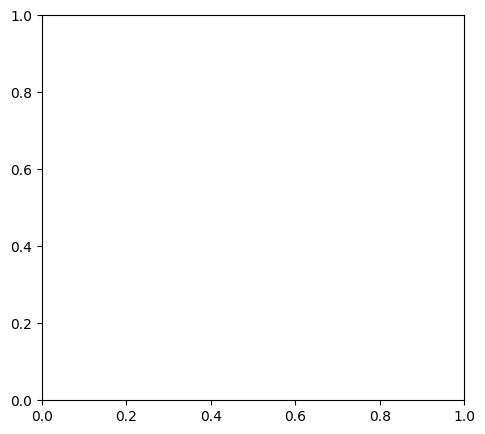

In [7]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels

# Evaluate classification accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot training loss & accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt


In [10]:
# Check class distribution
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print(f"Training Class Distribution: {dict(zip(unique, counts))}")

# Balance the dataset (Undersampling majority class)
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_train_balanced, y_train_balanced = rus.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

# Reshape back for LSTM input
X_train_balanced = X_train_balanced.reshape(X_train_balanced.shape[0], X_train.shape[1], 1)

# Train again with balanced dataset
history = model.fit(X_train_balanced, y_train_balanced, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate again
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nUpdated Classification Report:\n", classification_report(y_test, y_pred))


Training Class Distribution: {np.int64(0): np.int64(106), np.int64(1): np.int64(126)}
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4716 - loss: 0.7011 - val_accuracy: 0.6364 - val_loss: 0.6644
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5232 - loss: 0.6858 - val_accuracy: 0.5455 - val_loss: 0.7259
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5489 - loss: 0.6866 - val_accuracy: 0.3636 - val_loss: 0.7992
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5695 - loss: 0.6782 - val_accuracy: 0.2727 - val_loss: 0.8865
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6081 - loss: 0.6633 - val_accuracy: 0.2273 - val_loss: 0.9005
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5814 - loss: 0.6826 - val_accuracy: 0.2273 - val_loss: 0.8167
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5858 - loss: 0.6797 - val_accuracy: 0.2273 - val_loss: 0.7865
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [14]:
# Compute VWAP (Volume Weighted Average Price)
df["VWAP"] = (df["Close"] * df["Volume"]).cumsum() / df["Volume"].cumsum()

# Compute ADX (Average Directional Index)
df["ADX"] = ta.trend.ADXIndicator(df["High"], df["Low"], df["Close"], window=14).adx()

# Add more lagged returns (short-term memory)
for i in range(1, 4):
    df[f"Return_Lag_{i}"] = df["Return"].shift(i)

# Drop NaNs caused by lagging
df = df.dropna()

# Update feature list
feature_columns.extend(["VWAP", "ADX", "Return_Lag_1", "Return_Lag_2", "Return_Lag_3"])

# Redefine X and y
X = df[feature_columns].values
y = df["Target"].values


In [15]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization

# Define an improved LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),  
    BatchNormalization(),  # Normalize activations
    Dropout(0.3),  

    LSTM(100, return_sequences=False),  
    BatchNormalization(),  
    Dropout(0.3),

    Dense(50, activation="relu"),  
    Dense(1, activation="sigmoid")  # Binary classification (Buy/Sell)
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

# Print model summary
model.summary()


Epoch 1/30


/Users/heb1/Library/r-miniconda-arm64/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4764 - loss: 0.9554 - val_accuracy: 0.4583 - val_loss: 0.6971
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5425 - loss: 0.7868 - val_accuracy: 0.4583 - val_loss: 0.6986
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5315 - loss: 0.7689 - val_accuracy: 0.4583 - val_loss: 0.6995
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5897 - loss: 0.6881 - val_accuracy: 0.4583 - val_loss: 0.7012
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5107 - loss: 0.7718 - val_accuracy: 0.4583 - val_loss: 0.7059
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5015 - loss: 0.7613 - val_accuracy: 0.4583 - val_loss: 0.7093
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5333 - loss: 0.7108 - val_accuracy: 0.4583 - val_loss: 0.7100
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5436 - loss: 0.6897 - val_accuracy: 0.4583 - val_loss: 0.7056
Epoch 9/30


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 9, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 9, 100)         │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 380,505 (1.45 MB)

 Trainable params: 126,701 (494.93 KB)

 Non-trainable params: 400 (1.56 KB)

 Optimizer params: 253,404 (989.86 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Test Accuracy: 0.4407

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.44      1.00      0.61        26

    accuracy                           0.44        59
   macro avg       0.22      0.50      0.31        59
weighted avg       0.19      0.44      0.27        59



/Users/heb1/Library/r-miniconda-arm64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/heb1/Library/r-miniconda-arm64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/heb1/Library/r-miniconda-arm64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

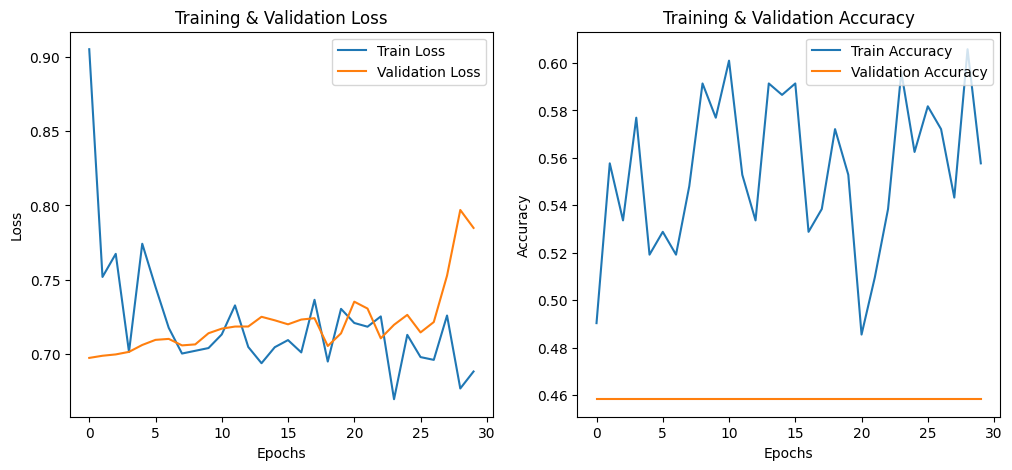

In [16]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot training loss & accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()
